In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import numpy as np # linear algebra
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
#import json
#from pandas.io.json import json_normalize
#from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv', 'sample_submission.csv']


In [42]:
train_df = pd.read_csv(
    'train-wrangled.csv',
    dtype={
        'fullVisitorId': 'str',
        'trafficSource.campaignCode': 'str',
        'visitId': 'str'
    },
    parse_dates=['date'])
train_df.shape

(903653, 55)

In [43]:
test_df = pd.read_csv(
    'test-wrangled.csv',
    dtype={
        'fullVisitorId': 'str',
        'trafficSource.campaignCode': 'str',
        'visitId': 'str'
    },
    parse_dates=['date'])
test_df.shape

(804684, 53)

In [44]:
first_date =  train_df['date'][0]
train_df['date'] = (train_df['date'] - first_date).dt.days
test_df['date'] = (test_df['date'] - first_date).dt.days

In [45]:
for feature in train_df.columns:
    if feature not in test_df.columns:
        print(feature)

totals.transactionRevenue
trafficSource.campaignCode


In [46]:
train_df.drop(columns=['trafficSource.campaignCode'], inplace=True)

In [47]:
const_cols = [
    c for c in train_df.columns if train_df[c].nunique(dropna=False) == 1
]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [48]:
cols_to_drop = const_cols
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

In [49]:
# Impute 0 for missing target values
cat_cols = train_df.select_dtypes(include='object').columns
num_cols = train_df.select_dtypes(include='number').columns
cat_cols = list(set(cat_cols) - set(['fullVisitorId', 'sessionId', 'visitId']))
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_df.loc[:,cat_cols].fillna(value='missing', inplace=True)

In [50]:
y_train = train_df["totals.transactionRevenue"]
X_train = train_df.drop(columns=["totals.transactionRevenue"])

In [ ]:
X_train = encoder.transform(X_train)

In [131]:
X_train = pd.read_csv(
    './X_train_imputed_categorical.csv',
    dtype={
        'fullVisitorId': 'str',
        'trafficSource.campaignCode': 'str',
        'visitId': 'str'
    })

X_test = pd.read_csv(
    './X_test_imputed_categorical.csv',
    dtype={
        'fullVisitorId': 'str',
        'trafficSource.campaignCode': 'str',
        'visitId': 'str'
    })

In [132]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[num_cols])

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [133]:
X_train[num_cols] = imputer.transform(X_train[num_cols])
X_test[num_cols] = imputer.transform(X_test[num_cols])

In [137]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [138]:
threshold = int(train_df.shape[0] * 0.8)
X_train_f = X_train.loc[:threshold].drop(columns=[
    'fullVisitorId', 'sessionId', 'visitId'])
y_train_f = y_train.loc[:threshold]
X_val_f = X_train.loc[threshold:].drop(columns=[
    'fullVisitorId', 'sessionId', 'visitId'])
y_val_f = y_train.loc[threshold:]

In [139]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(random_state=42, verbose=1, max_iter=100)
reg.fit(X_train_f, y_train_f)

-- Epoch 1
Norm: 1384303080602147840.00, NNZs: 30, Bias: 2831978114.608584, T: 722923, Avg. loss: 189599941250926375611892050874245421361304458747707392.000000
Total training time: 0.23 seconds.
-- Epoch 2
Norm: 1041378754825250432.00, NNZs: 30, Bias: 1796587333.069084, T: 1445846, Avg. loss: 79371675372377736528247857945143528830391552602800128.000000
Total training time: 0.47 seconds.
-- Epoch 3
Norm: 1432184529647454208.00, NNZs: 30, Bias: 403546066.334296, T: 2168769, Avg. loss: 60405312729540302280103775997413633361669681915625472.000000
Total training time: 0.71 seconds.
-- Epoch 4
Norm: 1168334986290195456.00, NNZs: 30, Bias: 656038528.004917, T: 2891692, Avg. loss: 50383096709309435611625095312988817310649783454531584.000000
Total training time: 0.95 seconds.
-- Epoch 5
Norm: 1209893669665810944.00, NNZs: 30, Bias: 1326876150.837851, T: 3614615, Avg. loss: 44966579071230643306485148817014571339159700093534208.000000
Total training time: 1.19 seconds.
-- Epoch 6
Norm: 1142955741

Norm: 592037977040146432.00, NNZs: 30, Bias: 3945282529.232381, T: 31085689, Avg. loss: 14971983115302577540902551241312985808858238110662656.000000
Total training time: 10.32 seconds.
-- Epoch 44
Norm: 554588247868603520.00, NNZs: 30, Bias: 5413683892.235686, T: 31808612, Avg. loss: 14621189383922568294739455840029893135282516965457920.000000
Total training time: 10.56 seconds.
-- Epoch 45
Norm: 539565199107461632.00, NNZs: 30, Bias: 4749090159.587694, T: 32531535, Avg. loss: 13861760825168696884858166440812250588361740481724416.000000
Total training time: 10.79 seconds.
-- Epoch 46
Norm: 593283073241727104.00, NNZs: 30, Bias: 6465408299.151134, T: 33254458, Avg. loss: 14088710815956405675327169736527753048083780488658944.000000
Total training time: 11.03 seconds.
-- Epoch 47
Norm: 620163338357805440.00, NNZs: 30, Bias: 8173419886.759077, T: 33977381, Avg. loss: 13856086414247150662382378977479736417309921799831552.000000
Total training time: 11.26 seconds.
-- Epoch 48
Norm: 607773154

Norm: 647229045111684736.00, NNZs: 30, Bias: 11888074307.344885, T: 61448455, Avg. loss: 10489517656818713423574072964267055534548205843775488.000000
Total training time: 20.32 seconds.
-- Epoch 86
Norm: 592870729932932992.00, NNZs: 30, Bias: 12226890597.182869, T: 62171378, Avg. loss: 10473850908814046607161668814510790819859625785950208.000000
Total training time: 20.56 seconds.
-- Epoch 87
Norm: 501120012989076288.00, NNZs: 30, Bias: 13013647641.743078, T: 62894301, Avg. loss: 10135240230040338831552568286187399488341663639666688.000000
Total training time: 20.80 seconds.
-- Epoch 88
Norm: 484518350700089024.00, NNZs: 30, Bias: 12901331560.496614, T: 63617224, Avg. loss: 10185766804783179580866687384330576885155298141011968.000000
Total training time: 21.04 seconds.
-- Epoch 89
Norm: 602409048019994240.00, NNZs: 30, Bias: 13459722075.266712, T: 64340147, Avg. loss: 10260950065692585424668353759008296018120176044081152.000000
Total training time: 21.28 seconds.
-- Epoch 90
Norm: 4232

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=100,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=1, warm_start=False)

In [140]:
pred_train = reg.predict(X_train_f)
pred_val = reg.predict(X_val_f)

### Training Score

In [141]:
pred_train.mean()

1.646358169766682e+26

In [124]:
from sklearn.metrics import mean_squared_error
pred_train[pred_train < 0] = 0
train_results_df = X_train.loc[:threshold,['fullVisitorId']]
train_results_df['real revenue'] = y_train_f
train_results_df['predicted value'] = np.expm1(pred_train)
train_results_df.groupby('fullVisitorId').sum()

print(
    np.sqrt(
        mean_squared_error(
            np.log1p(train_results_df["real revenue"].values),
            np.log1p(train_results_df["predicted value"].values))))

/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in expm1
  """
/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in log1p
  if sys.path[0] == '':
/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log1p
  if sys.path[0] == '':


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Testing Score

In [267]:
pred_val[pred_val < 0] = 0
val_results_df = val[['fullVisitorId']]
val_results_df['real revenue'] = val['totals.transactionRevenue']
val_results_df['predicted value'] = np.expm1(pred_val)
val_results_df.groupby('fullVisitorId').sum()

print(
    np.sqrt(
        metrics.mean_squared_error(
            np.log1p(val_results_df["real revenue"].values),
            np.log1p(val_results_df["predicted value"].values))))

/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


1.6259997643897068


In [268]:
def run_lgb(X_train, y_train):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1
    }

    lgtrain = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(
        params, lgtrain, 136, verbose_eval=100)

    return model


# Training the model #
model = run_lgb(X_train, y_train)

In [302]:
results = model.predict(test_df[X_train.columns])
results[results < 0] = 0
submission = test_df[['fullVisitorId']]
submission['PredictedLogRevenue'] = np.expm1(results)
submission = submission.groupby('fullVisitorId', as_index=False).sum()
submission.to_csv('baseline_lgb.csv', index=False)

/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [290]:
results = model.predict(test_df[X_train.columns])
results[results < 0] = 0
submission = test_df[['fullVisitorId']]
submission['PredictedLogRevenue'] = np.expm1(results).astype(int)
submission = submission.groupby('fullVisitorId', as_index=False).sum()
submission.to_csv('baseline_lgb_int.csv', index=False)

/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [296]:
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})
importance.sort_values(by='Importance', ascending=False, inplace=True)
importance

Feature  Importance
18                              totals.pageviews         758
16                                   totals.hits         710
1                                           date         517
2                                    visitNumber         359
3                                 visitStartTime         254
12                      geoNetwork.networkDomain         205
8                                geoNetwork.city         201
10                            geoNetwork.country         159
13                             geoNetwork.region         152
7                         device.operatingSystem         145
11                              geoNetwork.metro         109
29                    trafficSource.referralPath          89
26                    trafficSource.isTrueDirect          51
30                          trafficSource.source          47
27                         trafficSource.keyword          47
28                          trafficSource.medium          42
0                                channelGrouping          40
5                          device.deviceCategory          38
9                           geoNetwork.continent          37
6                                device.isMobile          36
4                                 device.browser          32
21          trafficSource.adwordsClickInfo.gclId          30
14                       geoNetwork.subContinent          13
25                        trafficSource.campaign           5
19                       trafficSource.adContent           4
17                              totals.newVisits           0
20  trafficSource.adwordsClickInfo.adNetworkType           0
22      trafficSource.adwordsClickInfo.isVideoAd           0
23           trafficSource.adwordsClickInfo.page           0
24           trafficSource.adwordsClickInfo.slot           0
15                                totals.bounces           0

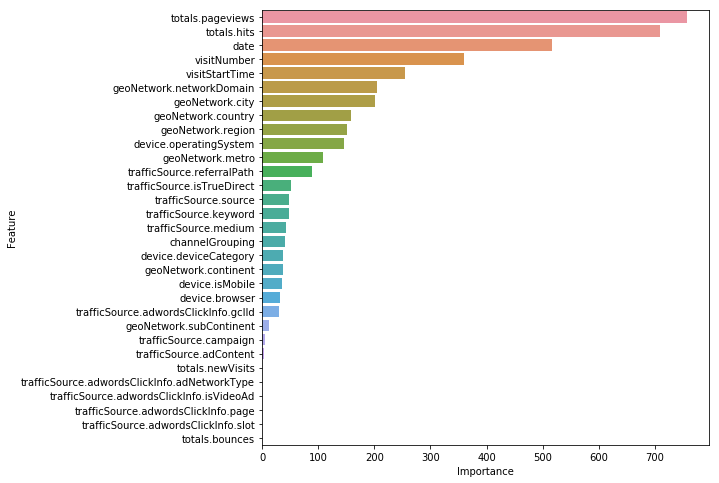

In [300]:
plt.figure(figsize=(8,8))
sns.barplot(data=importance, x='Importance', y='Feature')

Page number in search results where the ad was shown.
Here, order may be important. I will impute NAs with larger + 1

In [12]:
values = {
    'totals.bounces': 0,
    'totals.newVisits': 0,
    'totals.transactionRevenue': 0,
    'trafficSource.adwordsClickInfo.page': 15,
    'totals.pageviews': 1
}


def fill_na(df):
    df.fillna(value=values, inplace=True)
    df['totals.bounces'] = df['totals.bounces'].astype(int)
    df['totals.newVisits'] = df['totals.newVisits'].astype(int)
    df['trafficSource.adwordsClickInfo.page'] = df[
        'trafficSource.adwordsClickInfo.page'].astype(int)
    
    return df

In [13]:
train_df = fill_na(train_df)
test_df = fill_na(test_df)

Checking for single value features.

In [14]:
[c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]

['totals.visits']

It is obvious that `totals.visits` should be removed **for now** I will remove also the other two.

In [15]:
train_df.drop(columns=['totals.visits'], inplace=True)
test_df.drop(columns=['totals.visits'], inplace=True)

In [16]:
numerical = train_df.select_dtypes('number').columns
categorical = list(train_df.select_dtypes('object').columns)
categorical.append('device.isMobile')
for feature in ['fullVisitorId', 'sessionId', 'visitId']:
    categorical.remove(feature)

In [19]:
from sklearn.linear_model import SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [20]:
X = train_df.drop(columns=['totals.transactionRevenue'])
y = train_df['totals.transactionRevenue']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [21]:
from category_encoders import TargetEncoder

In [23]:
encoder = TargetEncoder(cols=categorical, verbose=10)

encoder.fit(X_train, y_train)

TargetEncoder(cols=['channelGrouping', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adContent', 'trafficSource.adw...d', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'device.isMobile'],
       drop_invariant=False, handle_unknown='impute', impute_missing=True,
       min_samples_leaf=1, return_df=True, smoothing=1, verbose=10)

In [26]:
from sklearn.externals import joblib
joblib.dump(encoder, 'mean_encoder.joblib')

['mean_encoder.joblib']

In [17]:
train = pd.get_dummies(train[categorical]).merge(train[numerical], left_index=True, right_index=True)
train.shape

(903553, 44)

In [20]:
def get_score(y_train, y_test, pred_train, pred_test):
    evaluate_train_df = train_original.loc[y_train.index, ['fullVisitorId']]
    evaluate_train_df['true'] = y_train
    evaluate_train_df['pred'] = pred_train
    evaluate_train_df = evaluate_train_df.groupby('fullVisitorId').sum()
    evaluate_train_df['true_log'] = np.log1p(evaluate_train_df['true'])
    evaluate_train_df['pred_log'] = np.log1p(evaluate_train_df['pred'])
    
    evaluate_test_df = train_original.loc[y_test.index, ['fullVisitorId']]
    evaluate_test_df['true'] = y_test
    evaluate_test_df['pred'] = pred_test
    evaluate_test_df = evaluate_test_df.groupby('fullVisitorId').sum()
    evaluate_test_df['true_log'] = np.log1p(evaluate_test_df['true'])
    evaluate_test_df['pred_log'] = np.log1p(evaluate_test_df['pred'])
    
    train_loss = np.sqrt(
        mean_squared_error(evaluate_train_df['true_log'],
                           evaluate_train_df['pred_log']))
    
    test_loss = np.sqrt(
        mean_squared_error(evaluate_test_df['true_log'],
                           evaluate_test_df['pred_log']))
    
    print('Train loss = ' + str(train_loss))
    print('Test loss = ' + str(test_loss))

### Stochastic Gradient Descent

In [38]:
reg = SGDRegressor(tol=0.001, max_iter=1000, random_state=42)
reg.fit(X_train, y_train)

pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

pred_train = reg.predict(X_train)
pred_train[pred_train < 0] = 0
pred_test = reg.predict(X_test)
pred_test[pred_test < 0] = 0.001

get_score(y_train, y_test, pred_train, pred_test)

Train loss = 2.117049250749518
Test loss = 2.0205232369401953


In [37]:
test = pd.read_csv('./test-wrangled.csv')
test.head()

/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


channelGrouping      date        fullVisitorId  \
0  Organic Search  20171016  6167871330617112363   
1  Organic Search  20171016  0643697640977915618   
2  Organic Search  20171016  6059383810968229466   
3  Organic Search  20171016  2376720078563423631   
4  Organic Search  20171016  2314544520795440038   

                        sessionId     visitId  visitNumber  visitStartTime  \
0  6167871330617112363_1508151024  1508151024            2      1508151024   
1  0643697640977915618_1508175522  1508175522            1      1508175522   
2  6059383810968229466_1508143220  1508143220            1      1508143220   
3  2376720078563423631_1508193530  1508193530            1      1508193530   
4  2314544520795440038_1508217442  1508217442            1      1508217442   

  device.browser device.deviceCategory  device.isMobile          ...           \
0         Chrome               desktop            False          ...            
1         Chrome               desktop            False          ...            
2         Chrome               desktop            False          ...            
3         Safari                mobile             True          ...            
4         Safari               desktop            False          ...            

  trafficSource.adwordsClickInfo.gclId  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

  trafficSource.adwordsClickInfo.isVideoAd  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

  trafficSource.adwordsClickInfo.page trafficSource.adwordsClickInfo.slot  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

  trafficSource.campaign trafficSource.isTrueDirect trafficSource.keyword  \
0                    NaN                       True                   NaN   
1                    NaN                        NaN                   NaN   
2                    NaN                        NaN                   NaN   
3                    NaN                        NaN                   NaN   
4                    NaN                        NaN                   NaN   

  trafficSource.medium  trafficSource.referralPath  trafficSource.source  
0              organic                         NaN                google  
1              organic                         NaN                google  
2              organic                         NaN                google  
3              organic                         NaN                google  
4              organic                         NaN                google  

[5 rows x 35 columns]

In [39]:
values = {
    'totals.bounces': 0,
    'totals.newVisits': 0,
    'totals.transactionRevenue': 0,
    'trafficSource.adwordsClickInfo.page': 15
}
test.fillna(value=values, inplace=True)
test['totals.bounces'] = test['totals.bounces'].astype(int)
test['totals.newVisits'] = test['totals.newVisits'].astype(int)
test['trafficSource.adwordsClickInfo.page'] = test[
    'trafficSource.adwordsClickInfo.page'].astype(int)

In [40]:
test.drop(
    columns=[
        'totals.visits', 'trafficSource.adwordsClickInfo.isVideoAd',
        'trafficSource.isTrueDirect'
    ],
    inplace=True)

In [42]:
numerical_test = numerical.drop('totals.transactionRevenue')
test = pd.get_dummies(test[categorical]).merge(
    test[numerical_test], left_index=True, right_index=True)
test.shape

(804684, 66)

In [45]:
test = test.loc[:, X.columns]
test.shape

(804684, 43)

In [48]:
test.fillna(0, inplace=True)

In [50]:
predictions = reg.predict(test)


-2.275352157704517e+26

In [51]:
sum(predictions > 0)

0